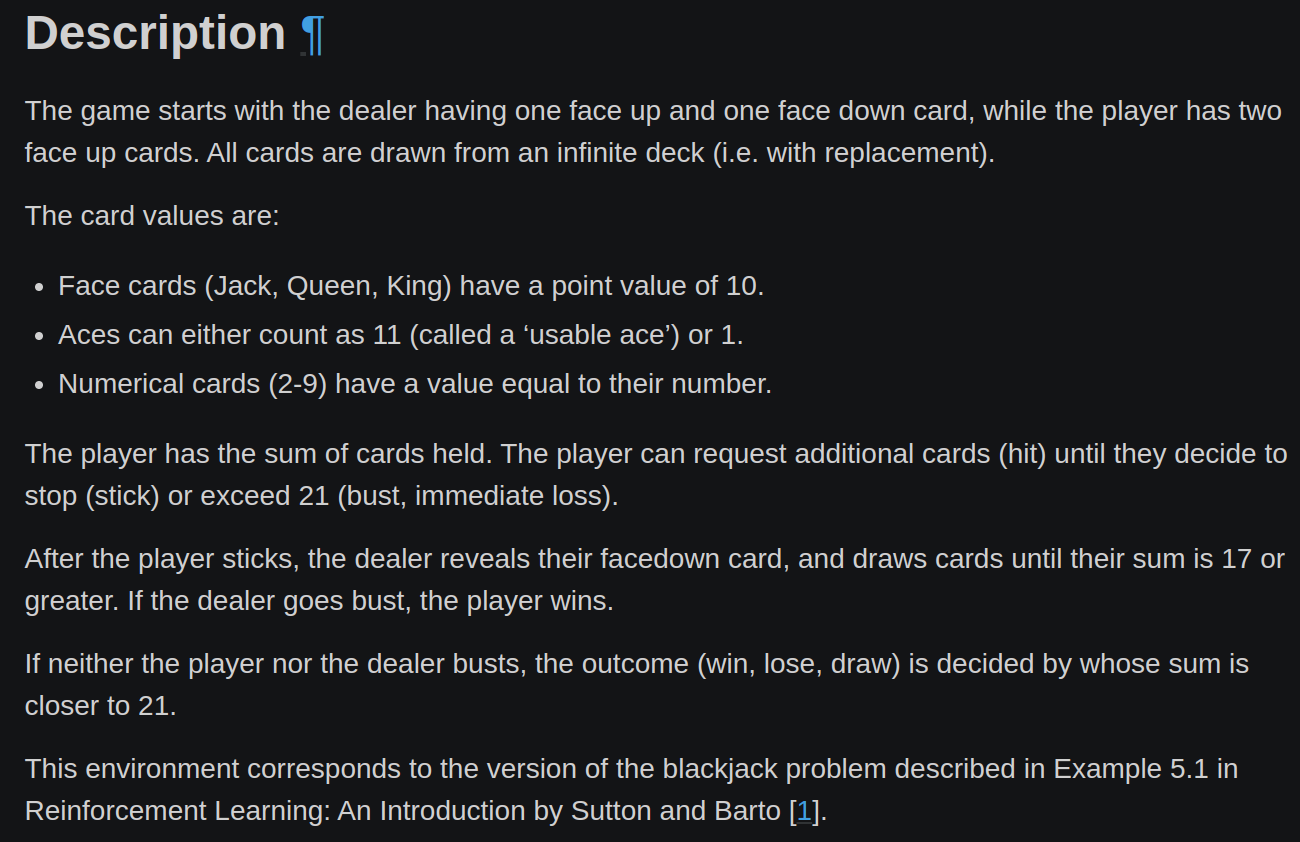

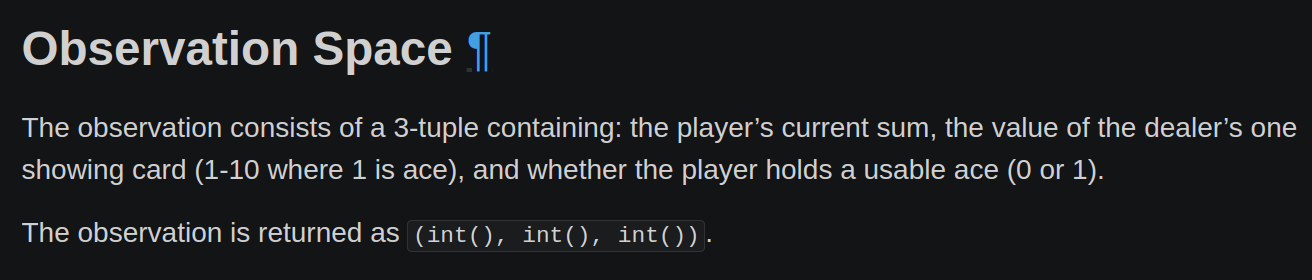

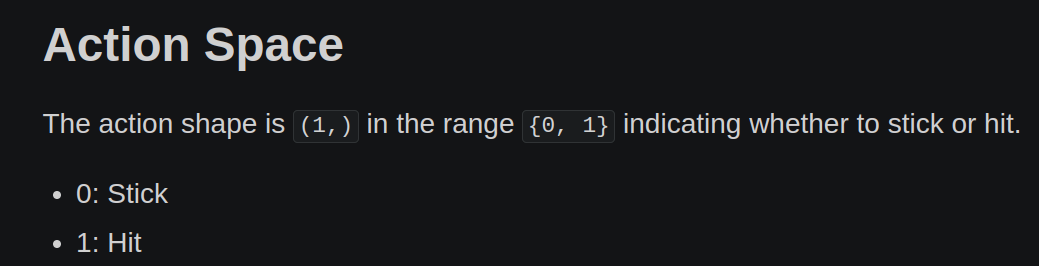

In [1]:
import gymnasium as gym
import random
import matplotlib.pyplot as plt
import math

In [2]:
env = gym.make("Blackjack-v1")

In [3]:
state, info = env.reset()
state, info

((15, 9, 0), {})

In [4]:
def init_policy():
    policy:dict[tuple[int, int, int], int] = {}
    for dealer_card in range(1, 10+1):
        for player_sum in range(1, 21+1):
            for has_ace in [1, 0]:
                policy[(player_sum, dealer_card, has_ace)] = random.randint(0, 1) # 0: stick, 1: hit
    return policy

def init_q_table():
    q_table:dict[tuple[int, int, int, int], float] = {}
    for dealer_card in range(1, 10+1): # Why 1-10? Because the dealer's first card is visible | And there are 10 possible values for a card (1-10)
        for player_sum in range(1, 21+1):  # Why 1-21? Because the player can have a sum of 21 (11 + 10) | And there are 10 possible values for a card (1-10)
            for has_ace in [1, 0]: # 1: True, 0: False
                for action in [0, 1]: # 0: stick, 1: hit
                    q_table[(player_sum, dealer_card, has_ace, action)] = 0.0
    return q_table

def returns_list():
    returns:dict[tuple[int, int, int, int], list[float]] = {}
    for dealer_card in range(1, 10+1):
        for player_sum in range(1, 21+1): # player card can get above 21, but the game ends when the player has a sum of 21
            for has_ace in [1, 0]:
                for action in [0, 1]:
                    returns[(player_sum, dealer_card, has_ace, action)] = []
    return returns

In [5]:
def epsilon_linear_decay(episode, epsilon_start, epsilon_min, decay_steps):
    if episode >= decay_steps:
        return epsilon_min
    epsilon = epsilon_start - (epsilon_start - epsilon_min) * (episode / decay_steps)
    return max(epsilon, epsilon_min)


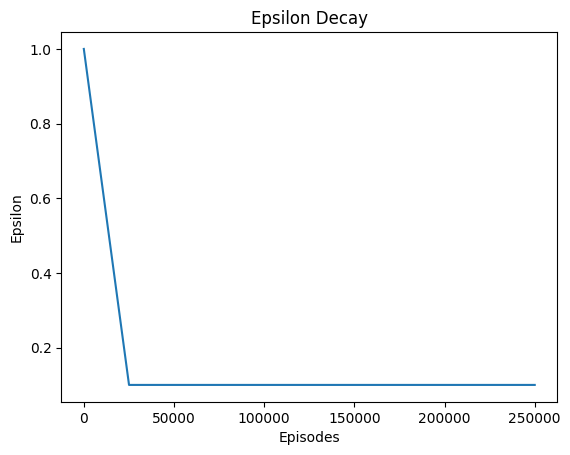

In [6]:
epsilon_start = 1.0   # Start with full exploration
epsilon_min = 0.1     # Minimum exploration rate
decay_rate = 0.005    # Decay rate
num_episodes = 250_000

epsilons = [epsilon_linear_decay(episode, epsilon_start, epsilon_min, decay_steps=num_episodes//10) for episode in range(num_episodes)]

# Plot epsilon decay
plt.plot(epsilons)
plt.xlabel("Episodes")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

In [7]:
def monte_carlo_exploring_starts(
        env:gym.Env, 
        epsilon_start:float,   # Start with full exploration
        epsilon_min:float,     # Minimum exploration rate
        num_episodes:int,
        gamma:float=1.0,
        log:bool=False
    ):
    policy_pi, q_table, returns = init_policy(), init_q_table(), returns_list()
    avg = lambda x: sum(x) / len(x)
    sum_rewards_list = []
    for ep in range(1, num_episodes+1):
        if log:print(f"|| Episode: {ep} ||", end="\t")
        state, info = env.reset()
        epsilon = epsilon_linear_decay(ep, epsilon_start, epsilon_min, decay_steps=num_episodes)

        episodes_list:list[tuple[tuple[int, int, int], int, int]] = []
        sum_reward = 0
        while True:
            if random.random() < epsilon: action = random.randint(0, 1)
            else: action = policy_pi[state]

            next_state, reward, done, truncated, info = env.step(action)
            episodes_list.append((state, action, reward))
            if log: print(f"|| Reward: {reward} ||", end=" ")
            sum_reward += reward
            if done or truncated:
                break
            state = next_state
        sum_rewards_list.append(sum_reward)
        if log: print()
        G = 0
        num_steps = len(episodes_list)
        for tstep in range(num_steps-1, -1, -1): # tstep: T-1 to 0 (including both ends)
            state, action, reward = episodes_list[tstep]
            G = gamma * G + reward

            # It checks if the state-action pair is already in the episode before the current time step (tstep)
            # If it is, then we don't need to calculate the return for this state-action pair AGAIN
            if (*state, action) not in [state_action_reward[:-1] for state_action_reward in episodes_list[:tstep]]:
                returns[(*state, action)].append(G)
                q_table[(*state, action)] = avg(returns[(*state, action)])
                policy_pi[state] = max([0, 1], key=lambda action: q_table[(*state, action)] )
    
    return policy_pi, q_table, returns, sum_rewards_list

In [8]:
policy_pi, q_table, returns, sum_rewards_list = monte_carlo_exploring_starts(
    env, epsilon_start=1.0, epsilon_min=0.1, num_episodes=250_000, gamma=1.0, log=False
)

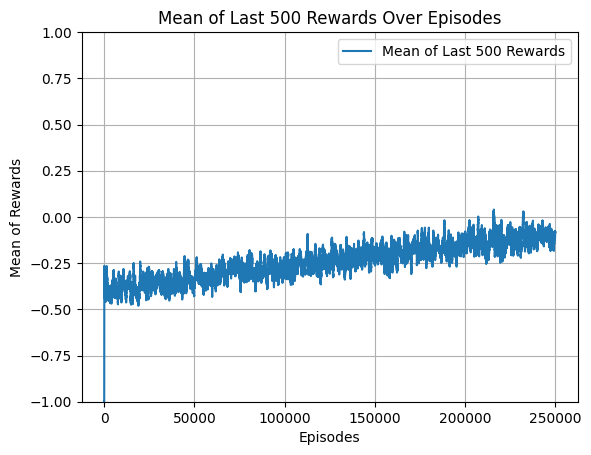

In [9]:
def plot_mean_of_last_n_rewards(rewards, n):
    means = [sum(rewards[max(0, i-n):i+1]) / (i - max(0, i-n) + 1) for i in range(len(rewards))]
    plt.plot(means, label=f"Mean of Last {n} Rewards")
    plt.ylim(-1, 1)
    plt.xlabel("Episodes")
    plt.ylabel("Mean of Rewards")
    plt.title(f"Mean of Last {n} Rewards Over Episodes")
    plt.grid()
    plt.legend()
    plt.show()

plot_mean_of_last_n_rewards(sum_rewards_list, 500)

In [10]:
num_won = len([reward for reward in sum_rewards_list if reward == 1])
num_lost = len([reward for reward in sum_rewards_list if reward == -1])
num_draw = len([reward for reward in sum_rewards_list if reward == 0])
print(f"Number of Wins: {num_won}")
print(f"Number of Losses: {num_lost}")
print(f"Number of Draws: {num_draw}")

Number of Wins: 87964
Number of Losses: 148032
Number of Draws: 14004


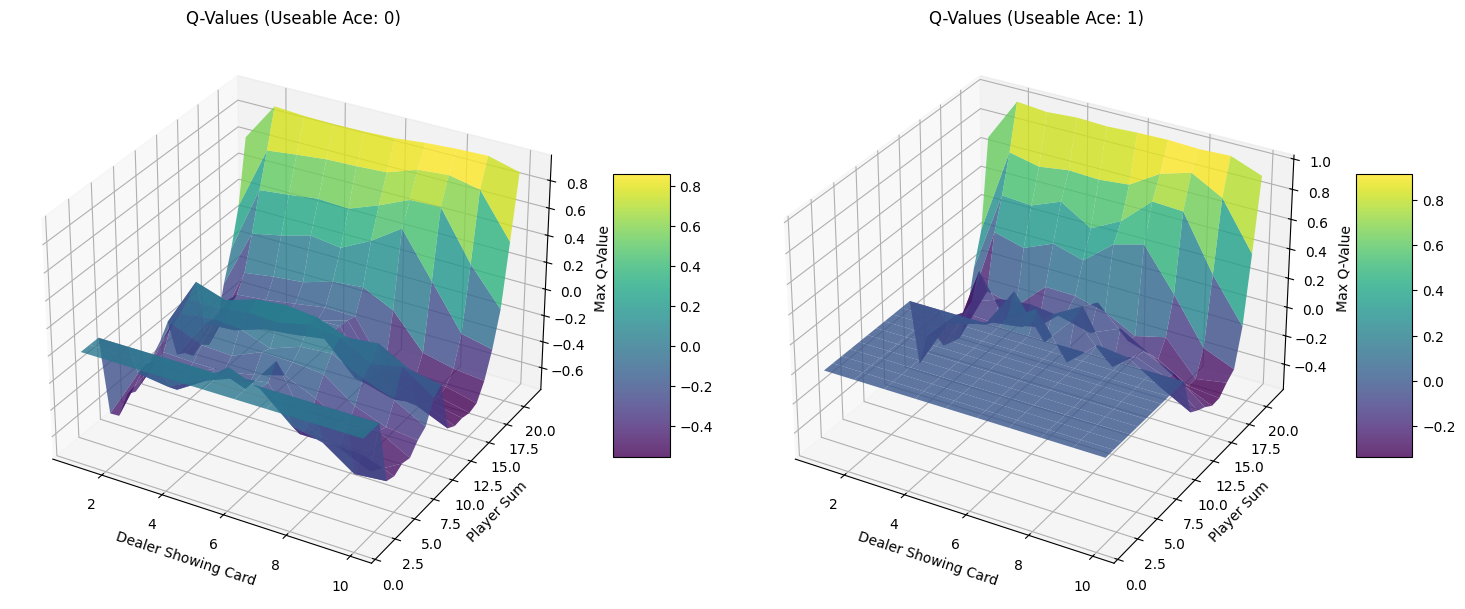

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_q_values(q_table):
    """
    Create a 3D plot of Q-values for Blackjack states.
    
    Parameters:
    -----------
    q_table : dict
        Dictionary with keys (player_sum, dealer_card, useable_ace)
        and Q-values as corresponding values
    """
    # Prepare data for plotting
    player_sums = list(set(key[0] for key in q_table.keys()))
    dealer_cards = list(set(key[1] for key in q_table.keys()))
    useable_ace_states = list(set(key[2] for key in q_table.keys()))
    
    # Create meshgrid for plotting
    X, Y = np.meshgrid(dealer_cards, player_sums)
    
    # Create subplots for each useable ace state
    fig = plt.figure(figsize=(15, 6))
    
    for i, has_ace in enumerate(useable_ace_states):
        # Create 3D subplot
        ax = fig.add_subplot(1, len(useable_ace_states), i+1, projection='3d')
        
        # Prepare Z values (Q-values)
        Z = np.zeros_like(X, dtype=float)
        for x_idx, dealer_card in enumerate(dealer_cards):
            for y_idx, player_sum in enumerate(player_sums):
                # Get the Q-value for hit and stick actions, take the max
                hit_q = q_table.get((player_sum, dealer_card, has_ace, 1), 0)
                stick_q = q_table.get((player_sum, dealer_card, has_ace, 0), 0)
                Z[y_idx, x_idx] = max(hit_q, stick_q)
        
        # Create 3D surface plot
        surf = ax.plot_surface(X, Y, Z, cmap='viridis', 
                                edgecolor='none', alpha=0.8)
        
        # Customize the plot
        ax.set_title(f'Q-Values (Useable Ace: {has_ace})')
        ax.set_xlabel('Dealer Showing Card')
        ax.set_ylabel('Player Sum')
        ax.set_zlabel('Max Q-Value')
        
        # Add a color bar
        fig.colorbar(surf, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have your trained q_table from Monte Carlo training
plot_q_values(q_table)

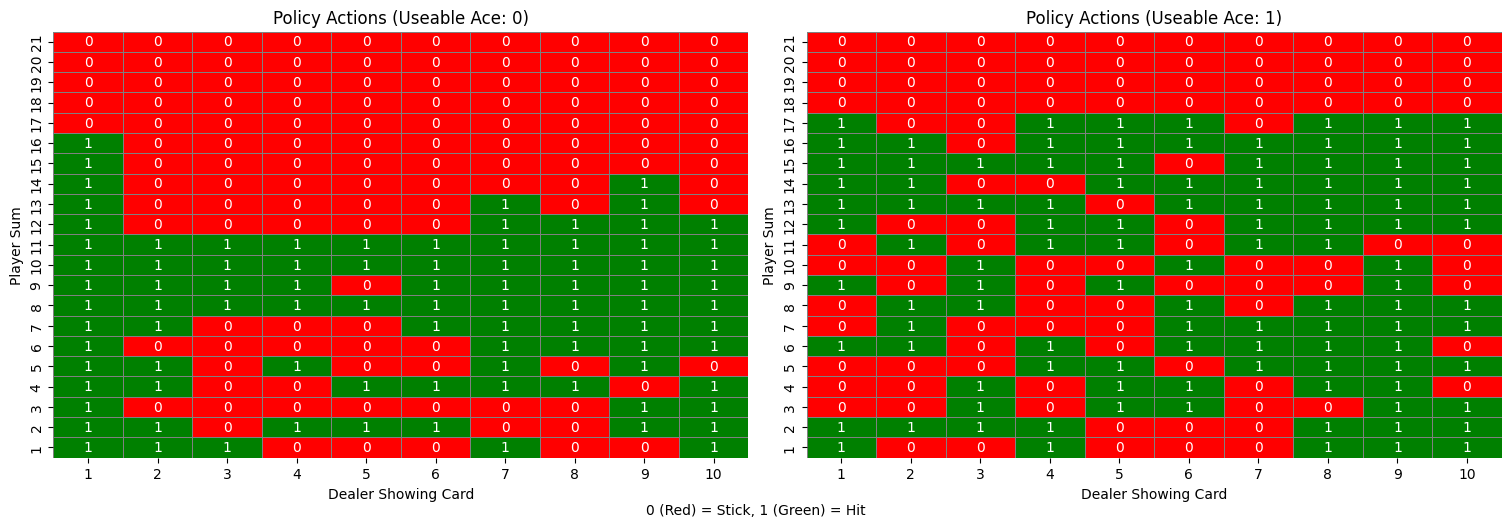

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_policy_actions(policy_pi):
    """
    Create a heatmap visualization of actions taken in different game states
    
    Parameters:
    -----------
    policy_pi : dict
        Dictionary with keys (player_sum, dealer_card, useable_ace)
        and actions (0: stick, 1: hit) as values
    """
    # Prepare data for plotting
    player_sums = sorted(list(set(key[0] for key in policy_pi.keys())))
    dealer_cards = sorted(list(set(key[1] for key in policy_pi.keys())))
    useable_ace_states = sorted(list(set(key[2] for key in policy_pi.keys())))
    
    # Create subplots for each useable ace state
    fig, axes = plt.subplots(1, len(useable_ace_states), 
                              figsize=(15, 5), 
                              constrained_layout=True)
    
    # Ensure axes is always a list, even if there's only one subplot
    if len(useable_ace_states) == 1:
        axes = [axes]
    
    # Color mapping for actions
    action_colors = {0: 'Stick', 1: 'Hit'}
    
    # Plot for each useable ace state
    for i, has_ace in enumerate(useable_ace_states):
        # Prepare action matrix
        action_matrix = np.zeros((len(player_sums), len(dealer_cards)), dtype=int)
        
        # Fill action matrix
        for x_idx, dealer_card in enumerate(dealer_cards):
            for y_idx, player_sum in enumerate(player_sums):
                # Ensure integer conversion
                action = int(policy_pi.get((player_sum, dealer_card, has_ace), 0))
                action_matrix[y_idx, x_idx] = action
        
        # Create heatmap
        sns.heatmap(action_matrix, 
                    ax=axes[i],
                    cmap=['red', 'green'],  # Stick (red), Hit (green)
                    cbar=False,
                    xticklabels=dealer_cards,
                    yticklabels=player_sums,
                    annot=True,  # Show numeric values
                    fmt='d',     # Integer formatting
                    linewidths=0.5,
                    linecolor='gray')
        
        # Invert y-axis so it starts from the bottom
        axes[i].invert_yaxis()
        
        axes[i].set_title(f'Policy Actions (Useable Ace: {has_ace})')
        axes[i].set_xlabel('Dealer Showing Card')
        axes[i].set_ylabel('Player Sum')
    
    # Add a custom legend
    fig.text(0.5, -0.01, 
             '0 (Red) = Stick, 1 (Green) = Hit', 
             ha='center', 
             va='center', 
             transform=fig.transFigure)
    
    plt.show()

# Example usage:
plot_policy_actions(policy_pi)